<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-06/Semi-Supervised-GAN-(SGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and Show data

4423680/4422102 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


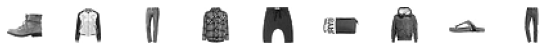

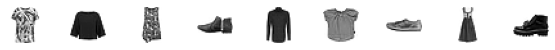

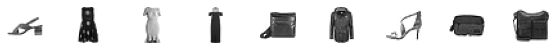

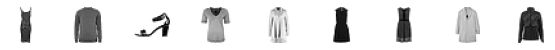

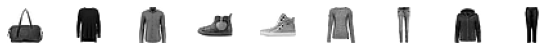

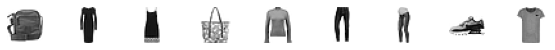

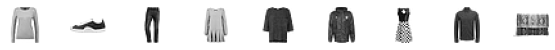

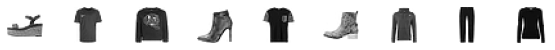

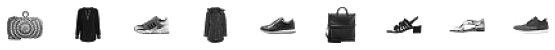

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

# Ten classes

In [ ]:
set(trainY)

# data normalization

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(5*5*64)(random_input)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 1600)              161600    
_________________________________________________________________
activation (Activation)      (None, 1600)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6400      
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 11, 11, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 128)       0     

# Define Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(4,4))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

features = tensorflow.keras.layers.Flatten()(x)

d_out1 = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out1)

d_out2 = tensorflow.keras.layers.Dense(11)(features)
class_output = tensorflow.keras.layers.Activation('softmax')(d_out2)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=[real_vs_fake_output, class_output])

print (discriminator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 128)  1280        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 13, 13, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 13, 13, 128)  512         leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [9]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer,\
                              metrics=['accuracy'], loss_weights=[0.5, 0.5])

# Define combined Model: SGAN

In [10]:
discriminator_network.trainable=False

g_output = generator_network(random_input)

d_output = discriminator_network(g_output)

real_vs_fake = d_output[0]
class_output = d_output[1]

ss_gan_model = tensorflow.keras.models.Model(inputs = random_input, outputs=real_vs_fake)
ss_gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         540097    
_________________________________________________________________
model_1 (Functional)         [(None, 1), (None, 11)]   562316    
Total params: 1,102,413
Trainable params: 536,385
Non-trainable params: 566,028
_________________________________________________________________


# Compiling SGAN

In [11]:
ss_gan_model.compile(loss=['binary_crossentropy'], optimizer=adam_optimizer)

# Define Utility Functions

In [12]:
indices = [i for i in range(0, len(trainX))]

def encode_class_input(value):
    x = np.zeros((11))
    x[value] = 1
    return x

def decode_class_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    real_classes = np.array([encode_class_input(x) for x in trainY[np.array(random_indices),]])
    return real_images, real_classes

def get_fake_classes(batch_size):
    fake_classes = []
    for i in range(batch_size):
        fake_class = encode_class_input(10)
        fake_classes.append(fake_class)
    return np.array(fake_classes)

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(9, 6))
        random_noise_batches = get_random_noise(10, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training SGAN

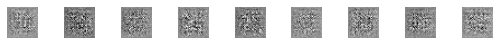

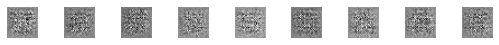

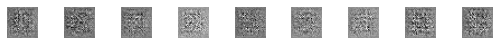

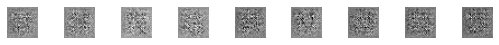

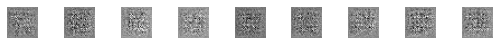

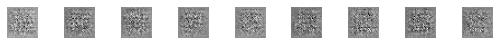

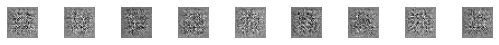

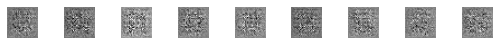

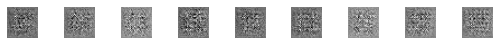

Epoch:0, Step:0, D-Loss:1.805, D-Acc:80.000, D-Acc-Classification:4.000, G-Loss:0.784
Epoch:0, Step:50, D-Loss:0.388, D-Acc:96.000, D-Acc-Classification:84.000, G-Loss:3.382
Epoch:0, Step:100, D-Loss:0.287, D-Acc:90.000, D-Acc-Classification:87.000, G-Loss:2.939
Epoch:0, Step:150, D-Loss:0.283, D-Acc:92.000, D-Acc-Classification:89.000, G-Loss:3.567
Epoch:0, Step:200, D-Loss:0.232, D-Acc:94.000, D-Acc-Classification:89.000, G-Loss:3.301
Epoch:0, Step:250, D-Loss:0.370, D-Acc:95.000, D-Acc-Classification:85.000, G-Loss:3.579
Epoch:0, Step:300, D-Loss:0.216, D-Acc:97.000, D-Acc-Classification:88.000, G-Loss:3.899
Epoch:0, Step:350, D-Loss:0.250, D-Acc:95.000, D-Acc-Classification:86.000, G-Loss:3.823
Epoch:0, Step:400, D-Loss:0.238, D-Acc:99.000, D-Acc-Classification:88.000, G-Loss:4.513
Epoch:0, Step:450, D-Loss:0.192, D-Acc:98.000, D-Acc-Classification:92.000, G-Loss:3.608
Epoch:1, Step:0, D-Loss:0.194, D-Acc:97.000, D-Acc-Classification:94.000, G-Loss:4.898
Epoch:1, Step:50, D-Loss:0.

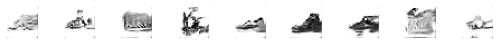

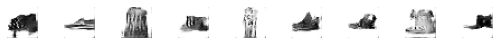

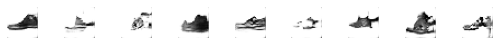

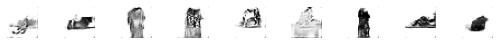

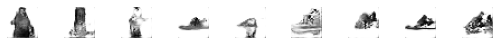

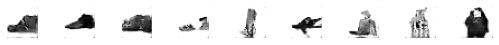

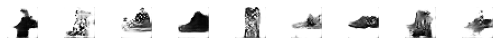

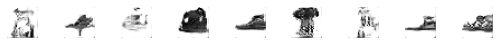

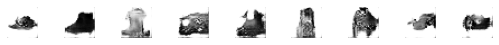

Epoch:5, Step:0, D-Loss:0.343, D-Acc:87.000, D-Acc-Classification:84.000, G-Loss:3.207
Epoch:5, Step:50, D-Loss:0.297, D-Acc:89.000, D-Acc-Classification:88.000, G-Loss:3.354
Epoch:5, Step:100, D-Loss:0.172, D-Acc:96.000, D-Acc-Classification:93.000, G-Loss:2.756
Epoch:5, Step:150, D-Loss:0.195, D-Acc:96.000, D-Acc-Classification:92.000, G-Loss:3.056
Epoch:5, Step:200, D-Loss:0.226, D-Acc:93.000, D-Acc-Classification:91.000, G-Loss:2.844
Epoch:5, Step:250, D-Loss:0.232, D-Acc:94.000, D-Acc-Classification:87.000, G-Loss:3.073
Epoch:5, Step:300, D-Loss:0.252, D-Acc:92.000, D-Acc-Classification:92.000, G-Loss:2.845
Epoch:5, Step:350, D-Loss:0.248, D-Acc:91.000, D-Acc-Classification:91.000, G-Loss:2.804
Epoch:5, Step:400, D-Loss:0.240, D-Acc:95.000, D-Acc-Classification:90.000, G-Loss:3.809
Epoch:5, Step:450, D-Loss:0.301, D-Acc:93.000, D-Acc-Classification:90.000, G-Loss:3.802
Epoch:6, Step:0, D-Loss:0.140, D-Acc:99.000, D-Acc-Classification:94.000, G-Loss:3.360
Epoch:6, Step:50, D-Loss:0

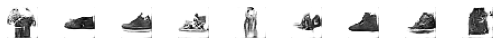

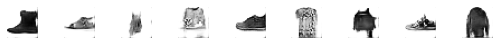

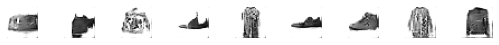

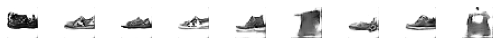

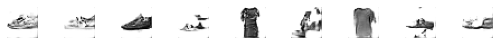

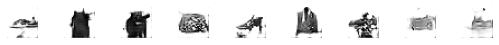

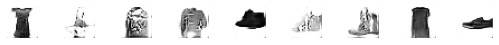

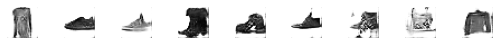

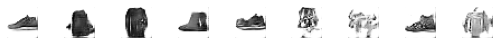

Epoch:10, Step:0, D-Loss:0.242, D-Acc:95.000, D-Acc-Classification:92.000, G-Loss:2.447
Epoch:10, Step:50, D-Loss:0.359, D-Acc:83.000, D-Acc-Classification:85.000, G-Loss:2.191
Epoch:10, Step:100, D-Loss:0.278, D-Acc:90.000, D-Acc-Classification:90.000, G-Loss:2.009
Epoch:10, Step:150, D-Loss:0.337, D-Acc:85.000, D-Acc-Classification:86.000, G-Loss:4.275
Epoch:10, Step:200, D-Loss:0.201, D-Acc:94.000, D-Acc-Classification:93.000, G-Loss:2.461
Epoch:10, Step:250, D-Loss:0.256, D-Acc:91.000, D-Acc-Classification:89.000, G-Loss:2.528
Epoch:10, Step:300, D-Loss:0.436, D-Acc:87.000, D-Acc-Classification:79.000, G-Loss:2.694
Epoch:10, Step:350, D-Loss:0.240, D-Acc:92.000, D-Acc-Classification:92.000, G-Loss:3.421
Epoch:10, Step:400, D-Loss:0.230, D-Acc:92.000, D-Acc-Classification:92.000, G-Loss:2.230
Epoch:10, Step:450, D-Loss:0.266, D-Acc:92.000, D-Acc-Classification:87.000, G-Loss:2.077
Epoch:11, Step:0, D-Loss:0.245, D-Acc:92.000, D-Acc-Classification:88.000, G-Loss:2.492
Epoch:11, Step:

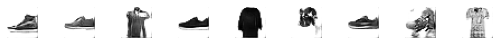

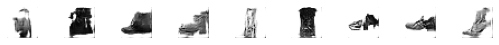

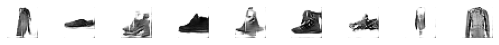

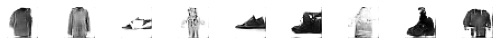

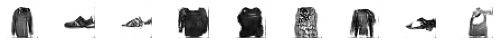

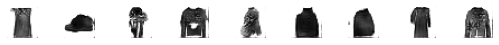

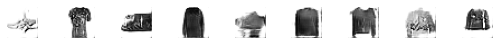

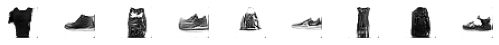

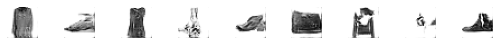

Epoch:15, Step:0, D-Loss:0.322, D-Acc:88.000, D-Acc-Classification:90.000, G-Loss:2.196
Epoch:15, Step:50, D-Loss:0.410, D-Acc:83.000, D-Acc-Classification:87.000, G-Loss:2.721
Epoch:15, Step:100, D-Loss:0.288, D-Acc:89.000, D-Acc-Classification:88.000, G-Loss:2.941
Epoch:15, Step:150, D-Loss:0.410, D-Acc:84.000, D-Acc-Classification:82.000, G-Loss:2.844
Epoch:15, Step:200, D-Loss:0.302, D-Acc:92.000, D-Acc-Classification:87.000, G-Loss:2.698
Epoch:15, Step:250, D-Loss:0.275, D-Acc:90.000, D-Acc-Classification:90.000, G-Loss:1.688
Epoch:15, Step:300, D-Loss:0.307, D-Acc:88.000, D-Acc-Classification:90.000, G-Loss:2.331
Epoch:15, Step:350, D-Loss:0.370, D-Acc:85.000, D-Acc-Classification:83.000, G-Loss:2.769
Epoch:15, Step:400, D-Loss:0.272, D-Acc:89.000, D-Acc-Classification:89.000, G-Loss:2.538
Epoch:15, Step:450, D-Loss:0.275, D-Acc:92.000, D-Acc-Classification:88.000, G-Loss:3.342
Epoch:16, Step:0, D-Loss:0.400, D-Acc:84.000, D-Acc-Classification:84.000, G-Loss:2.258
Epoch:16, Step:

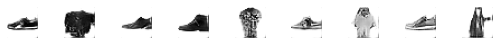

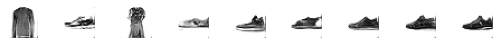

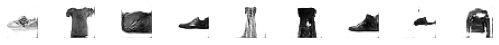

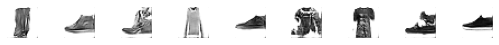

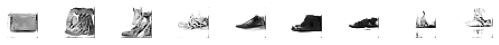

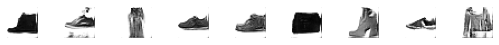

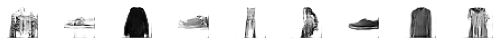

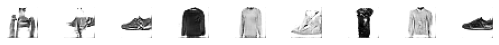

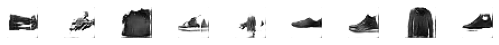

Epoch:20, Step:0, D-Loss:0.329, D-Acc:87.000, D-Acc-Classification:87.000, G-Loss:2.495
Epoch:20, Step:50, D-Loss:0.370, D-Acc:85.000, D-Acc-Classification:82.000, G-Loss:3.028
Epoch:20, Step:100, D-Loss:0.314, D-Acc:90.000, D-Acc-Classification:85.000, G-Loss:2.493
Epoch:20, Step:150, D-Loss:0.306, D-Acc:90.000, D-Acc-Classification:87.000, G-Loss:1.436
Epoch:20, Step:200, D-Loss:0.265, D-Acc:89.000, D-Acc-Classification:91.000, G-Loss:2.179
Epoch:20, Step:250, D-Loss:0.270, D-Acc:92.000, D-Acc-Classification:87.000, G-Loss:2.054
Epoch:20, Step:300, D-Loss:0.400, D-Acc:85.000, D-Acc-Classification:84.000, G-Loss:1.417
Epoch:20, Step:350, D-Loss:0.352, D-Acc:88.000, D-Acc-Classification:83.000, G-Loss:1.488
Epoch:20, Step:400, D-Loss:0.345, D-Acc:89.000, D-Acc-Classification:88.000, G-Loss:2.128
Epoch:20, Step:450, D-Loss:0.455, D-Acc:78.000, D-Acc-Classification:81.000, G-Loss:2.121
Epoch:21, Step:0, D-Loss:0.364, D-Acc:84.000, D-Acc-Classification:84.000, G-Loss:1.436
Epoch:21, Step:

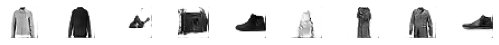

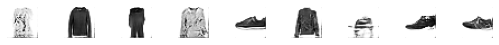

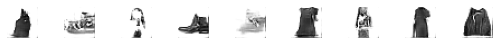

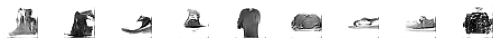

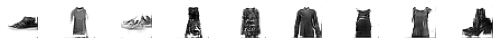

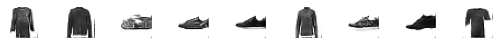

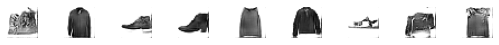

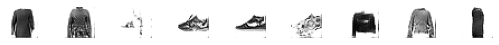

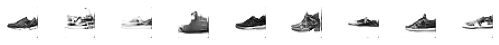

Epoch:25, Step:0, D-Loss:0.310, D-Acc:85.000, D-Acc-Classification:86.000, G-Loss:1.862
Epoch:25, Step:50, D-Loss:0.313, D-Acc:88.000, D-Acc-Classification:87.000, G-Loss:2.413
Epoch:25, Step:100, D-Loss:0.335, D-Acc:87.000, D-Acc-Classification:88.000, G-Loss:2.645
Epoch:25, Step:150, D-Loss:0.296, D-Acc:84.000, D-Acc-Classification:86.000, G-Loss:2.441
Epoch:25, Step:200, D-Loss:0.308, D-Acc:85.000, D-Acc-Classification:87.000, G-Loss:2.279
Epoch:25, Step:250, D-Loss:0.304, D-Acc:90.000, D-Acc-Classification:90.000, G-Loss:1.852
Epoch:25, Step:300, D-Loss:0.384, D-Acc:85.000, D-Acc-Classification:85.000, G-Loss:2.723
Epoch:25, Step:350, D-Loss:0.325, D-Acc:89.000, D-Acc-Classification:87.000, G-Loss:2.906
Epoch:25, Step:400, D-Loss:0.314, D-Acc:86.000, D-Acc-Classification:88.000, G-Loss:2.404
Epoch:25, Step:450, D-Loss:0.346, D-Acc:86.000, D-Acc-Classification:86.000, G-Loss:1.163
Epoch:26, Step:0, D-Loss:0.342, D-Acc:88.000, D-Acc-Classification:87.000, G-Loss:2.192
Epoch:26, Step:

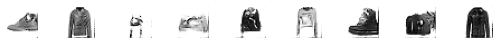

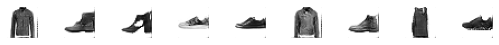

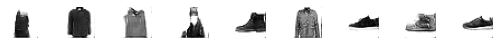

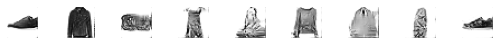

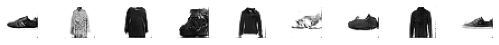

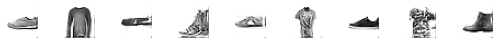

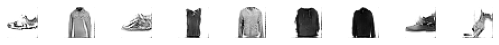

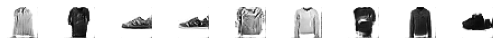

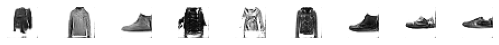

Epoch:30, Step:0, D-Loss:0.297, D-Acc:88.000, D-Acc-Classification:88.000, G-Loss:2.589
Epoch:30, Step:50, D-Loss:0.311, D-Acc:89.000, D-Acc-Classification:88.000, G-Loss:2.959
Epoch:30, Step:100, D-Loss:0.345, D-Acc:86.000, D-Acc-Classification:81.000, G-Loss:3.024
Epoch:30, Step:150, D-Loss:0.432, D-Acc:80.000, D-Acc-Classification:83.000, G-Loss:2.168
Epoch:30, Step:200, D-Loss:0.432, D-Acc:82.000, D-Acc-Classification:78.000, G-Loss:1.827
Epoch:30, Step:250, D-Loss:0.371, D-Acc:83.000, D-Acc-Classification:80.000, G-Loss:2.467
Epoch:30, Step:300, D-Loss:0.462, D-Acc:83.000, D-Acc-Classification:80.000, G-Loss:1.524
Epoch:30, Step:350, D-Loss:0.355, D-Acc:86.000, D-Acc-Classification:89.000, G-Loss:2.173
Epoch:30, Step:400, D-Loss:0.333, D-Acc:84.000, D-Acc-Classification:87.000, G-Loss:2.151
Epoch:30, Step:450, D-Loss:0.358, D-Acc:88.000, D-Acc-Classification:85.000, G-Loss:2.033
Epoch:31, Step:0, D-Loss:0.308, D-Acc:89.000, D-Acc-Classification:90.000, G-Loss:1.934
Epoch:31, Step:

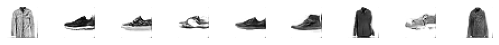

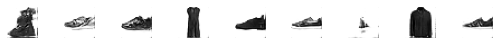

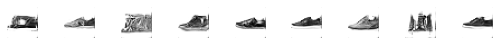

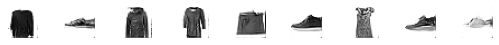

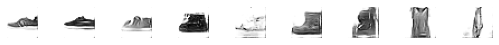

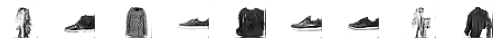

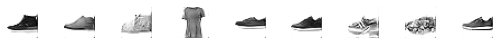

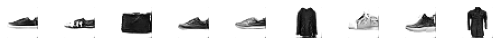

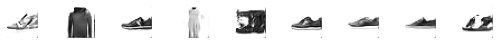

Epoch:35, Step:0, D-Loss:0.465, D-Acc:84.000, D-Acc-Classification:81.000, G-Loss:2.761
Epoch:35, Step:50, D-Loss:0.372, D-Acc:87.000, D-Acc-Classification:86.000, G-Loss:2.374
Epoch:35, Step:100, D-Loss:0.411, D-Acc:84.000, D-Acc-Classification:81.000, G-Loss:2.535
Epoch:35, Step:150, D-Loss:0.321, D-Acc:88.000, D-Acc-Classification:87.000, G-Loss:2.410
Epoch:35, Step:200, D-Loss:0.365, D-Acc:82.000, D-Acc-Classification:81.000, G-Loss:1.786
Epoch:35, Step:250, D-Loss:0.370, D-Acc:80.000, D-Acc-Classification:83.000, G-Loss:2.180
Epoch:35, Step:300, D-Loss:0.399, D-Acc:83.000, D-Acc-Classification:86.000, G-Loss:1.498
Epoch:35, Step:350, D-Loss:0.330, D-Acc:86.000, D-Acc-Classification:85.000, G-Loss:1.698
Epoch:35, Step:400, D-Loss:0.284, D-Acc:90.000, D-Acc-Classification:91.000, G-Loss:2.201
Epoch:35, Step:450, D-Loss:0.450, D-Acc:79.000, D-Acc-Classification:76.000, G-Loss:1.699
Epoch:36, Step:0, D-Loss:0.271, D-Acc:92.000, D-Acc-Classification:87.000, G-Loss:2.327
Epoch:36, Step:

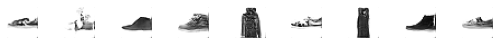

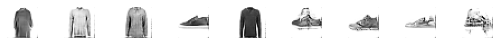

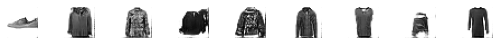

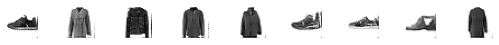

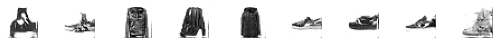

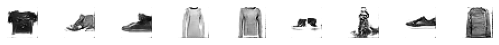

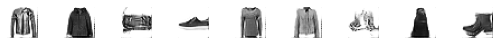

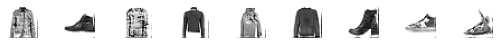

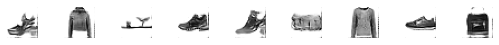

Epoch:40, Step:0, D-Loss:0.377, D-Acc:81.000, D-Acc-Classification:84.000, G-Loss:1.790
Epoch:40, Step:50, D-Loss:0.393, D-Acc:82.000, D-Acc-Classification:80.000, G-Loss:1.682
Epoch:40, Step:100, D-Loss:0.486, D-Acc:78.000, D-Acc-Classification:84.000, G-Loss:1.400
Epoch:40, Step:150, D-Loss:0.414, D-Acc:81.000, D-Acc-Classification:81.000, G-Loss:2.239
Epoch:40, Step:200, D-Loss:0.417, D-Acc:86.000, D-Acc-Classification:86.000, G-Loss:2.126
Epoch:40, Step:250, D-Loss:0.301, D-Acc:86.000, D-Acc-Classification:86.000, G-Loss:1.421
Epoch:40, Step:300, D-Loss:0.356, D-Acc:84.000, D-Acc-Classification:87.000, G-Loss:2.010
Epoch:40, Step:350, D-Loss:0.385, D-Acc:86.000, D-Acc-Classification:83.000, G-Loss:2.425
Epoch:40, Step:400, D-Loss:0.379, D-Acc:80.000, D-Acc-Classification:85.000, G-Loss:1.086
Epoch:40, Step:450, D-Loss:0.385, D-Acc:84.000, D-Acc-Classification:87.000, G-Loss:2.480
Epoch:41, Step:0, D-Loss:0.346, D-Acc:84.000, D-Acc-Classification:85.000, G-Loss:1.979
Epoch:41, Step:

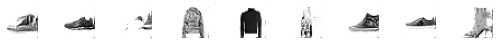

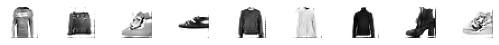

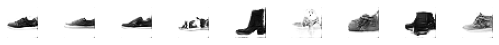

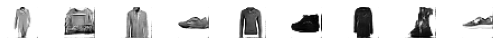

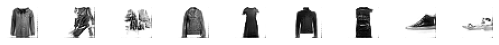

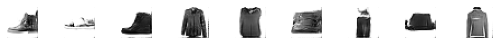

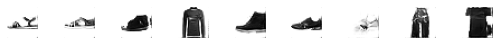

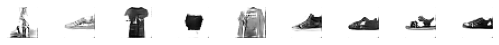

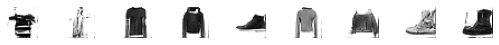

Epoch:45, Step:0, D-Loss:0.404, D-Acc:81.000, D-Acc-Classification:86.000, G-Loss:1.996
Epoch:45, Step:50, D-Loss:0.235, D-Acc:88.000, D-Acc-Classification:92.000, G-Loss:2.248
Epoch:45, Step:100, D-Loss:0.337, D-Acc:88.000, D-Acc-Classification:90.000, G-Loss:1.849
Epoch:45, Step:150, D-Loss:0.257, D-Acc:89.000, D-Acc-Classification:93.000, G-Loss:1.864
Epoch:45, Step:200, D-Loss:0.283, D-Acc:91.000, D-Acc-Classification:87.000, G-Loss:2.104
Epoch:45, Step:250, D-Loss:0.343, D-Acc:84.000, D-Acc-Classification:83.000, G-Loss:2.385
Epoch:45, Step:300, D-Loss:0.393, D-Acc:78.000, D-Acc-Classification:87.000, G-Loss:1.598
Epoch:45, Step:350, D-Loss:0.352, D-Acc:87.000, D-Acc-Classification:83.000, G-Loss:1.655
Epoch:45, Step:400, D-Loss:0.355, D-Acc:86.000, D-Acc-Classification:84.000, G-Loss:1.855
Epoch:45, Step:450, D-Loss:0.286, D-Acc:91.000, D-Acc-Classification:92.000, G-Loss:2.395
Epoch:46, Step:0, D-Loss:0.373, D-Acc:83.000, D-Acc-Classification:83.000, G-Loss:2.205
Epoch:46, Step:

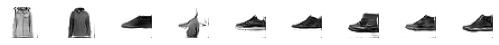

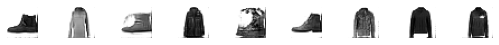

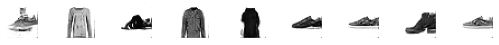

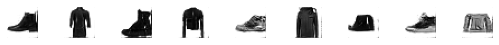

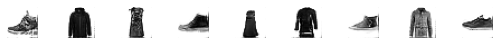

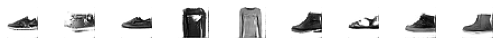

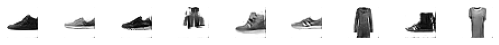

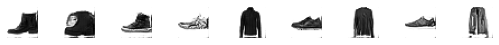

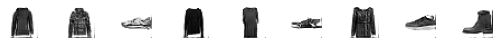

Epoch:50, Step:0, D-Loss:0.320, D-Acc:86.000, D-Acc-Classification:86.000, G-Loss:2.213
Epoch:50, Step:50, D-Loss:0.347, D-Acc:84.000, D-Acc-Classification:85.000, G-Loss:1.838
Epoch:50, Step:100, D-Loss:0.396, D-Acc:83.000, D-Acc-Classification:85.000, G-Loss:2.159
Epoch:50, Step:150, D-Loss:0.440, D-Acc:81.000, D-Acc-Classification:83.000, G-Loss:2.286
Epoch:50, Step:200, D-Loss:0.433, D-Acc:83.000, D-Acc-Classification:77.000, G-Loss:1.200
Epoch:50, Step:250, D-Loss:0.403, D-Acc:81.000, D-Acc-Classification:82.000, G-Loss:1.593
Epoch:50, Step:300, D-Loss:0.320, D-Acc:88.000, D-Acc-Classification:83.000, G-Loss:2.083
Epoch:50, Step:350, D-Loss:0.382, D-Acc:80.000, D-Acc-Classification:86.000, G-Loss:1.776
Epoch:50, Step:400, D-Loss:0.388, D-Acc:76.000, D-Acc-Classification:84.000, G-Loss:2.563
Epoch:50, Step:450, D-Loss:0.302, D-Acc:87.000, D-Acc-Classification:88.000, G-Loss:2.344
Epoch:51, Step:0, D-Loss:0.394, D-Acc:77.000, D-Acc-Classification:81.000, G-Loss:2.358
Epoch:51, Step:

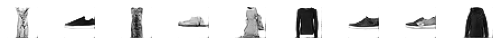

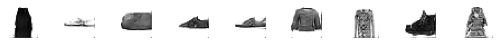

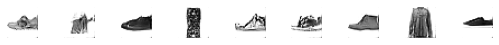

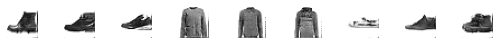

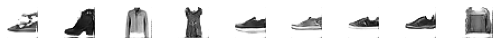

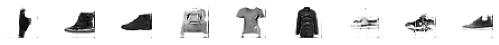

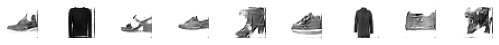

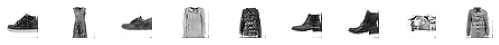

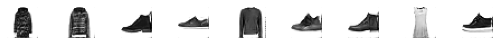

Epoch:55, Step:0, D-Loss:0.481, D-Acc:75.000, D-Acc-Classification:78.000, G-Loss:2.336
Epoch:55, Step:50, D-Loss:0.375, D-Acc:84.000, D-Acc-Classification:83.000, G-Loss:2.132
Epoch:55, Step:100, D-Loss:0.320, D-Acc:85.000, D-Acc-Classification:91.000, G-Loss:1.592
Epoch:55, Step:150, D-Loss:0.459, D-Acc:78.000, D-Acc-Classification:78.000, G-Loss:1.696
Epoch:55, Step:200, D-Loss:0.285, D-Acc:90.000, D-Acc-Classification:89.000, G-Loss:1.904
Epoch:55, Step:250, D-Loss:0.365, D-Acc:84.000, D-Acc-Classification:84.000, G-Loss:2.042
Epoch:55, Step:300, D-Loss:0.371, D-Acc:80.000, D-Acc-Classification:81.000, G-Loss:2.208
Epoch:55, Step:350, D-Loss:0.388, D-Acc:84.000, D-Acc-Classification:86.000, G-Loss:1.911
Epoch:55, Step:400, D-Loss:0.368, D-Acc:81.000, D-Acc-Classification:87.000, G-Loss:2.607
Epoch:55, Step:450, D-Loss:0.282, D-Acc:87.000, D-Acc-Classification:92.000, G-Loss:2.286
Epoch:56, Step:0, D-Loss:0.288, D-Acc:88.000, D-Acc-Classification:88.000, G-Loss:3.007
Epoch:56, Step:

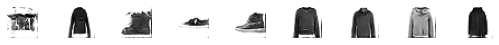

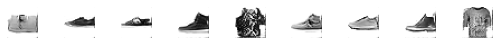

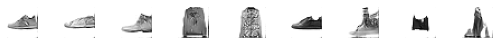

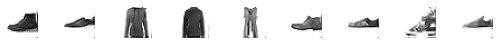

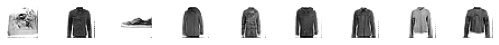

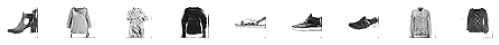

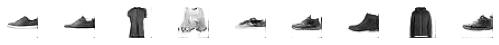

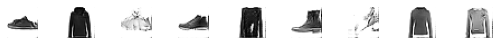

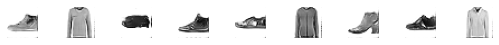

Epoch:60, Step:0, D-Loss:0.348, D-Acc:87.000, D-Acc-Classification:85.000, G-Loss:2.961
Epoch:60, Step:50, D-Loss:0.340, D-Acc:81.000, D-Acc-Classification:86.000, G-Loss:2.093
Epoch:60, Step:100, D-Loss:0.336, D-Acc:84.000, D-Acc-Classification:81.000, G-Loss:2.042
Epoch:60, Step:150, D-Loss:0.390, D-Acc:79.000, D-Acc-Classification:82.000, G-Loss:1.578
Epoch:60, Step:200, D-Loss:0.401, D-Acc:82.000, D-Acc-Classification:82.000, G-Loss:2.509
Epoch:60, Step:250, D-Loss:0.284, D-Acc:90.000, D-Acc-Classification:88.000, G-Loss:2.651
Epoch:60, Step:300, D-Loss:0.321, D-Acc:85.000, D-Acc-Classification:86.000, G-Loss:2.866
Epoch:60, Step:350, D-Loss:0.399, D-Acc:83.000, D-Acc-Classification:85.000, G-Loss:1.956
Epoch:60, Step:400, D-Loss:0.370, D-Acc:85.000, D-Acc-Classification:85.000, G-Loss:2.083
Epoch:60, Step:450, D-Loss:0.320, D-Acc:87.000, D-Acc-Classification:87.000, G-Loss:2.505
Epoch:61, Step:0, D-Loss:0.388, D-Acc:83.000, D-Acc-Classification:83.000, G-Loss:2.240
Epoch:61, Step:

KeyboardInterrupt: ignored

In [13]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%5 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        fake_classes = get_fake_classes(batch_size//2)
        real_samples, real_classes = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        class_labels = np.vstack((fake_classes, real_classes))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, [output_labels, class_labels])
        
        noise_batches = get_random_noise(batch_size, noise_size)
        ss_gan_input = noise_batches
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        ss_gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = ss_gan_model.train_on_batch(ss_gan_input, ss_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, D-Acc-Classification:%.3f, G-Loss:%.3f"%\
                   (i,j,loss_d[0],loss_d[3]*100,loss_d[4]*100,loss_g))
            

# Results

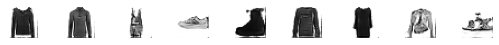

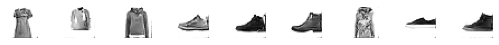

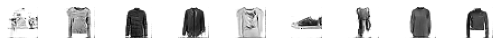

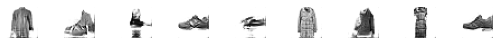

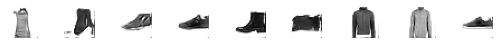

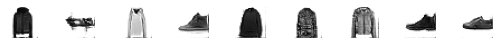

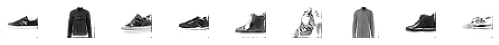

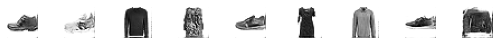

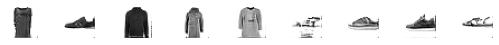

----------------------------------------------------------------------------------------------------


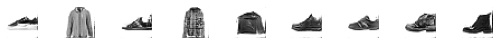

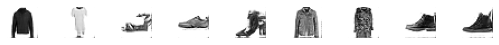

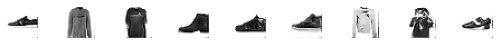

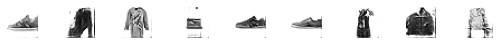

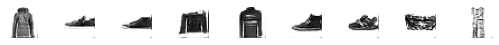

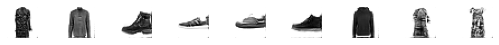

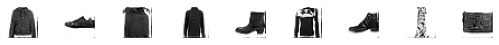

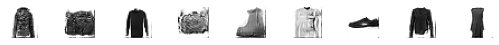

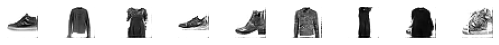

----------------------------------------------------------------------------------------------------


In [14]:
for i in range(2):
    show_generator_results(generator_network)
    print("-"*100)